# Petal to metal 

## Data Augmentation and training

Kaggle link: https://www.kaggle.com/c/tpu-getting-started

## Main Libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import re

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import experimental
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers,initializers

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## General Settings

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
GCS_DS_Path = '/content/gdrive/MyDrive/Kaggle/petals_to_the_metal/tpu-getting-started'  
IMAGE_SIZE = [224,224]
GCS_PATH = GCS_DS_Path + '/tfrecords-jpeg-224x224'

In [ ]:
training_file = tf.io.gfile.glob(GCS_PATH+'/train/*.tfrec') 
test_file = tf.io.gfile.glob(GCS_PATH+'/test/*.tfrec')
valid_file = tf.io.gfile.glob(GCS_PATH+'/val/*.tfrec')

In [ ]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [ ]:
def get_training_dataset(shuffle = False):
    dataset = load_dataset(training_file, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    if shuffle == True:
        dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(valid_file, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(test_file, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

## Testing reading

In [ ]:
BATCH_SIZE = 1 * strategy.num_replicas_in_sync

ds_train = get_training_dataset(shuffle = True)
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

In [ ]:
print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(1, 224, 224, 3) (1,)
(1, 224, 224, 3) (1,)
(1, 224, 224, 3) (1,)
Training data label examples: [48]


In [ ]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U'))

Test data shapes:
(1, 224, 224, 3) (1,)
(1, 224, 224, 3) (1,)
(1, 224, 224, 3) (1,)
Test data IDs: ['98f62f563']


(224, 224, 3)


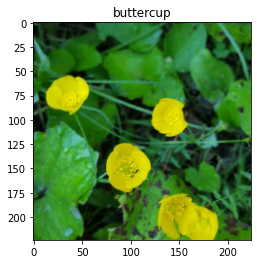

In [ ]:
image, label = next(iter(ds_train))
image = image[0].numpy()
label = label[0].numpy()
_ = plt.imshow(image)
_ = plt.title(CLASSES[label])
print(image.shape)

In [ ]:
data_augmentation = tf.keras.Sequential([
  experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
image = tf.expand_dims(image, 0)

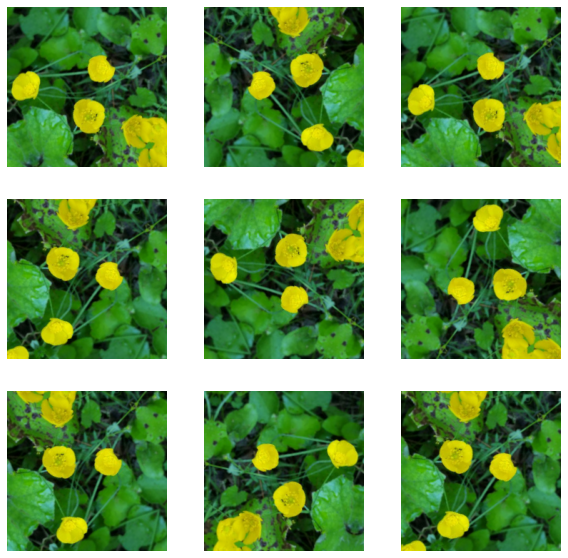

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

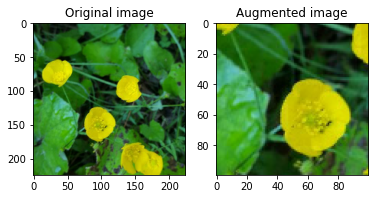

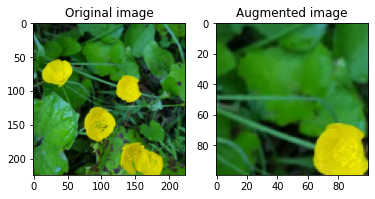

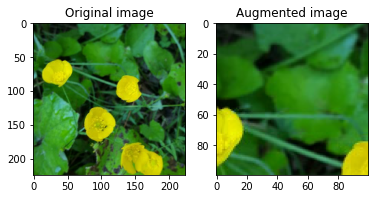

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(image, size=[1,100, 100, 3], seed=seed)
  visualize(image[0], stateless_random_crop[0])

Searching more images for the weak classes

In [2]:
from skimage import io
import cv2

In [4]:
# Read image from web image
image = io.imread('https://en.wikipedia.org/wiki/Eryngium_alpinum#/media/File:Alpen-Mannstreu_(Eryngium_alpinum)_04.jpg')

# Display image
cv2.imshow('image', image)
cv2.waitKey()

ValueError: ignored